# Problem Description 
You own the mall and want to understand the customers who can easily converge [Target Customers] so that the sense can be given to the marketing team and plan the strategy accordingly. <br>
Your goal here is to determine which customers are a good target for your marketing department. <br>

Problem link from Kaggle: [Mall Customer Segmentation Data](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

# References and Resources:
  Theory: [StatQuest: K-means clustering](https://www.youtube.com/watch?v=4b5d3muPQmA) <br>
  Notebooks: 
  - https://www.kaggle.com/code/kushal1996/customer-segmentation-k-means-analysis
  - https://www.kaggle.com/code/tanmay111999/unsupervised-learning-3-6-clusters-k-means-eda
  - https://www.kaggle.com/code/vjchoudhary7/kmeans-clustering-in-customer-segmentation/notebook

# Solution Approach
- Analyze Dataset
  - Find important columns for clustering
  - Visualize 2D plots for each set of columns to find relationship
- Use of a scaler to normalize/scale column values
- Finding the Optimal Number of Clusters
  - Visualize Elbow-plot to find right number of clusters
  - Selecting the number of clusters k using the silhouette score
- Run the KMeans clustering algorithm
- Visualize the result and describe it in words

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True) # initializing plotly in offline notebook mode
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # for mounting data from google drive

Mounted at /content/drive


## Loading and Analyzing the dataset


In [ ]:
df = pd.read_csv("drive/MyDrive/google_colab_data/mall_customer_segmentation_data/Mall_Customers.csv")
print(f"Shape: {df.shape[0]} rows & {df.shape[1]} columns\nColumns: {list(df.columns)}")
df.head()

Shape: 200 rows & 5 columns
Columns: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000    

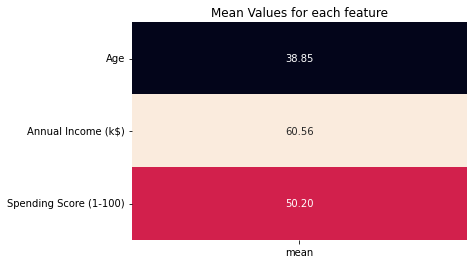

In [ ]:
# Finding mean values for each numerical feature
sns.heatmap(df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].describe().T[['mean']],annot = True,fmt = '.2f', cbar = False);
plt.title('Mean Values for each feature');

In [ ]:
df["isMale"] = np.where(df['Gender'] == 'Male', 1, 0) # creating new feature isMale for visualization purposes 

In [ ]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),isMale
0,1,Male,19,15,39,1
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


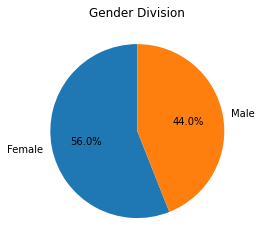

In [ ]:
l = list(df['Gender'].value_counts())
circle = [l[0] / len(l) * 100, l[1] / len(l) * 100]
plt.pie(circle,labels = ['Female','Male'],autopct='%1.1f%%',startangle = 90)
plt.title('Gender Division');
plt.show()

Almost equal number of male and female customers.

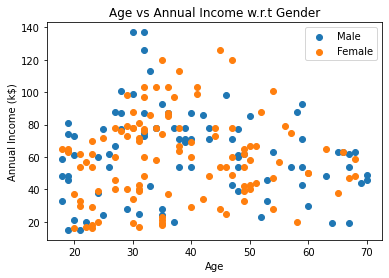

In [ ]:
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = df[df['Gender'] == gender], label = gender)
plt.xlabel('Age'), plt.ylabel('Annual Income (k$)') 
plt.title('Age vs Annual Income w.r.t Gender')
plt.legend()
plt.show()

As we can see, Male and Female customers are homogeneously distributed among Age vs Annual Income scatter plot.

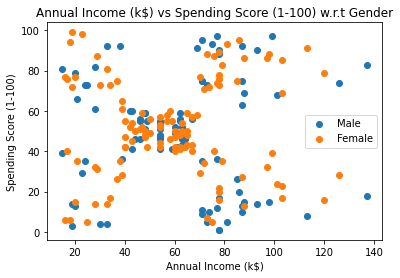

In [ ]:
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Annual Income (k$)' , y = 'Spending Score (1-100)' , data = df[df['Gender'] == gender], label = gender)
plt.xlabel('Annual Income (k$)'), plt.ylabel('Spending Score (1-100)') 
plt.title('Annual Income (k$) vs Spending Score (1-100) w.r.t Gender')
plt.legend()
plt.show()

As we can see, Male and Female customers are homogeneously distributed among Annual Income vs Spending score scatter plot.




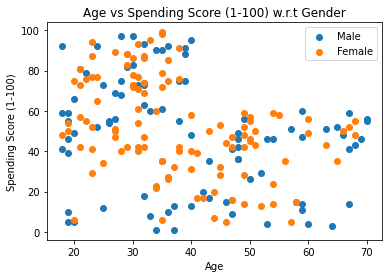

In [ ]:
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Spending Score (1-100)' , data = df[df['Gender'] == gender], label = gender)
plt.xlabel('Age'), plt.ylabel('Spending Score (1-100)') 
plt.title('Age vs Spending Score (1-100) w.r.t Gender')
plt.legend()
plt.show()

As we can see, Male and Female customers are homogeneously distributed among Spending score vs Age scatter plot.

In [ ]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),isMale
0,1,Male,19,15,39,1
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


## Elbow plot to find the optimal number of clusters

[308812.78, 212840.1698209719, 143342.751571706, 104366.15145556197, 75378.76464074483, 58302.40630860368, 51118.949931647294, 44312.46881207722, 40894.98978213978, 37468.51571576572, 34174.55217264217]


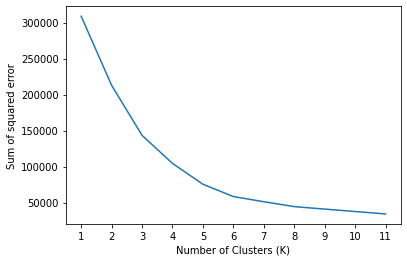

In [ ]:
k_range = range(1,12)
sse = []
for k in k_range:
  km = KMeans(n_clusters=k, init='k-means++', random_state=42)
  km.fit(df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]])
  sse.append(km.inertia_)
print(sse)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of squared error")
plt.xticks(k_range)
plt.plot(k_range, sse, )

Keep in mind, the plot will change in shape after we normalize the values using MinMaxScaler()

In [ ]:
scaler = MinMaxScaler()
data = df.copy(deep = True)
data['Age'] = scaler.fit_transform(data[['Age']])
data['Annual Income (k$)'] = scaler.fit_transform(data[['Annual Income (k$)']])
data['Spending Score (1-100)'] = scaler.fit_transform(data[['Spending Score (1-100)']])

## Dropping unnecessary columns <br>
    Remaining Columns:
    Age	Annual Income (k$)	Spending Score (1-100)

In [ ]:
data.drop(['CustomerID', 'Gender', 'isMale'], axis=1, inplace=True)

In [ ]:
print(f"Info about final data:\n")
data.info()
print(f"\nDescription of final data:\n")
data.describe()

Info about final data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Annual Income (k$)      200 non-null    float64
 2   Spending Score (1-100)  200 non-null    float64
dtypes: float64(3)
memory usage: 4.8 KB

Description of final data:



,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,0.400962,0.373443,0.502041
std,0.268635,0.215285,0.263505
min,0.000000,0.000000,0.000000
25%,0.206731,0.217213,0.344388
50%,0.346154,0.381148,0.500000
75%,0.596154,0.516393,0.734694
max,1.000000,1.000000,1.000000


## Visualizing elbow plot after normalizing

In [ ]:
k_range = range(1,12)
sse = []
for k in k_range:
  km = KMeans(n_clusters=k, init='k-means++', random_state=42)
  km.fit(data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]])
  sse.append(km.inertia_)
print(sse)

[37.401482160359436, 22.56077488260975, 17.371946164404164, 12.650287676229915, 10.303964892534122, 8.385099035848985, 7.4634835751996285, 6.248886770318164, 5.483963011692648, 5.032571050877738, 4.564291908894802]


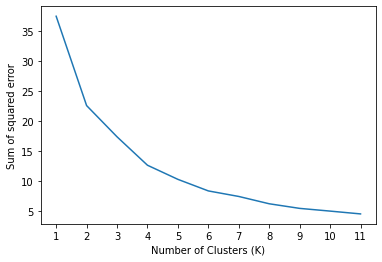

In [ ]:
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of squared error")
plt.xticks(k_range)
plt.plot(k_range, sse)



> We can see that the elbow can be thought of as being around 4 or 6



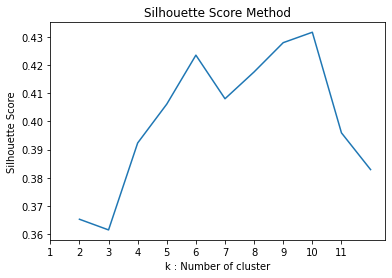

In [ ]:
sil = []
for k in k_range:
    kmeans = KMeans(n_clusters = k+1, init='k-means++', random_state=42).fit(data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]])
    labels = kmeans.labels_
    sil.append(silhouette_score(data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]], labels, metric = 'euclidean'))
sns.lineplot(x = range(2,k_range.stop + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.xticks(k_range)
plt.show()

We choose -> 6, as the number of clusters for our dataset.

## Running the KMeans Algorithm on reduced dataset

In [ ]:
model = KMeans(n_clusters = 6,max_iter = 1000, init='k-means++', random_state=42)
model.fit(data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]])
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_
print(labels)

[2 4 2 4 2 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0
 4 0 4 3 4 0 4 0 4 3 2 2 2 3 2 2 3 3 3 3 3 2 3 3 2 3 3 3 2 3 3 2 2 3 3 3 3
 3 2 3 2 2 3 3 2 3 3 2 3 3 2 2 3 3 2 3 2 2 2 3 2 3 2 2 3 3 2 3 2 3 3 3 3 3
 2 2 2 2 2 3 3 3 3 2 2 1 1 2 1 5 1 5 1 5 1 2 1 2 1 5 1 2 1 5 1 2 1 2 1 5 1
 5 1 5 1 5 1 5 1 5 1 5 1 3 1 2 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5
 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1]


In [ ]:
data["cluster"] = labels
data[:10]

,Age,Annual Income (k$),Spending Score (1-100),cluster,labels
0,0.019231,0.000000,0.387755,2,0
1,0.057692,0.000000,0.816327,4,0
2,0.038462,0.008197,0.051020,2,0
3,0.096154,0.008197,0.775510,4,0
4,0.250000,0.016393,0.397959,2,0
5,0.076923,0.016393,0.765306,4,0
6,0.326923,0.024590,0.051020,0,2
7,0.096154,0.024590,0.948980,4,0
8,0.884615,0.032787,0.020408,0,2
9,0.230769,0.032787,0.724490,4,0


## Plotting the scatterplot by coloring using their cluster_no

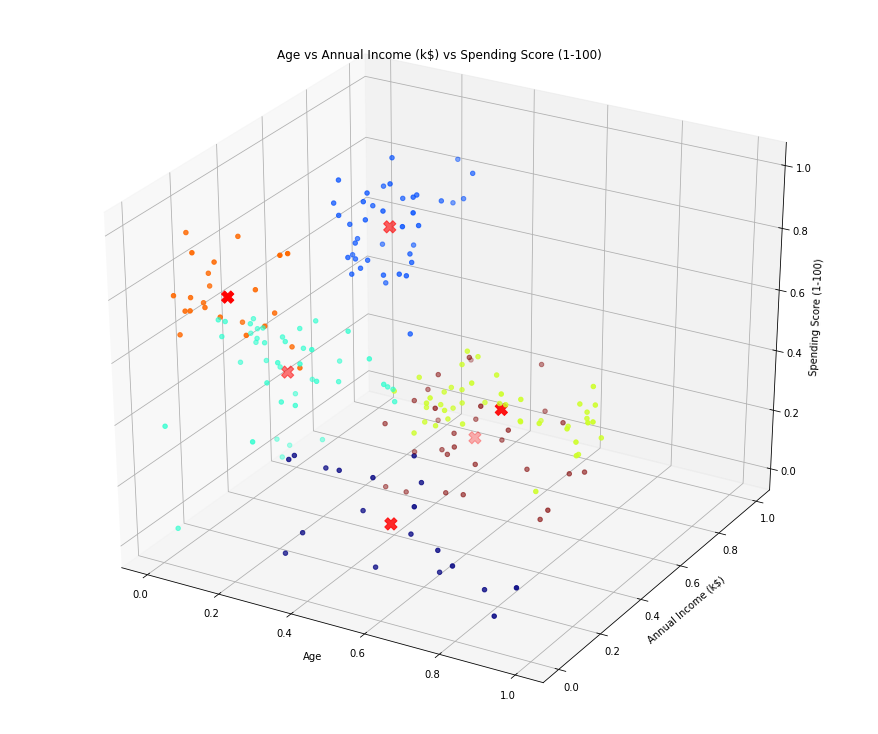

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = Axes3D(fig)
colors = ["red", "yellow", "green", "blue"]
# Using the normalized dataset for scatterplot
scatter = ax.scatter(data["Age"], data["Annual Income (k$)"], data["Spending Score (1-100)"], c=data["cluster"], cmap="jet")
ax.set_xlabel("Age")
ax.set_ylabel("Annual Income (k$)")
ax.set_zlabel("Spending Score (1-100)")
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2], marker = "X", color = 'red', s = 150)
plt.title('Age vs Annual Income (k$) vs Spending Score (1-100)')
plt.show()

As we can see, some of the clusters are clearly different from all other clusters. For example, blue and orange clusters. <br> But visualizing in 3D may reveal a different picture.

In [ ]:
data['labels'] = labels
trace = go.Scatter3d(
    x= df['Age'],
    y= df['Annual Income (k$)'],
    z= df['Spending Score (1-100)'],
    mode='markers',
     marker=dict(
        color = data['labels'], 
        size= 20,
        line=dict(
            color= data['labels'],
            width= 12
        ),
        opacity=0.8
     )
)
trace_data = [trace]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=trace_data, layout=layout)
py.offline.iplot(fig)

Collab doesn't show the 3D plot very clearly. So here's the link: [3D_output.html](https://drive.google.com/file/d/1sDgcmr3yWQyTiars5q_GVsK0t6EH4yqM/view?usp=sharing)

In [ ]:
fig.write_html("drive/MyDrive/google_colab_data/mall_customer_segmentation_data/3d_clustering_output.html")

(-0.5, 744.5, 678.5, -0.5)

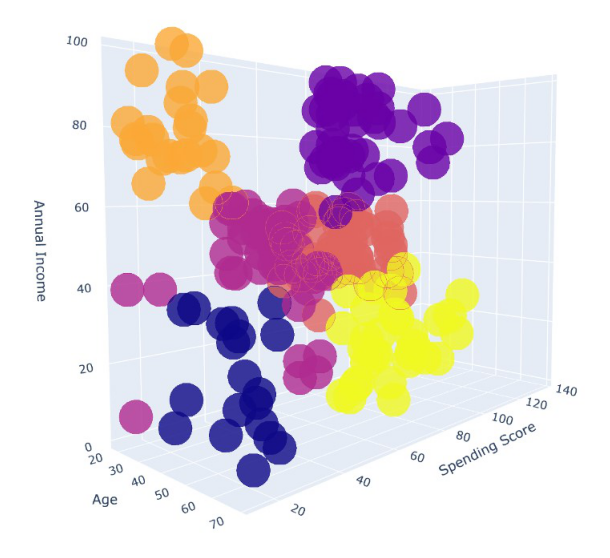

In [ ]:
plt.figure(figsize=(12, 10))
img = plt.imread('drive/MyDrive/google_colab_data/mall_customer_segmentation_data/3d_clustering_output1.jpg')
plt.imshow(img)
plt.axis('off')

(-0.5, 575.5, 684.5, -0.5)

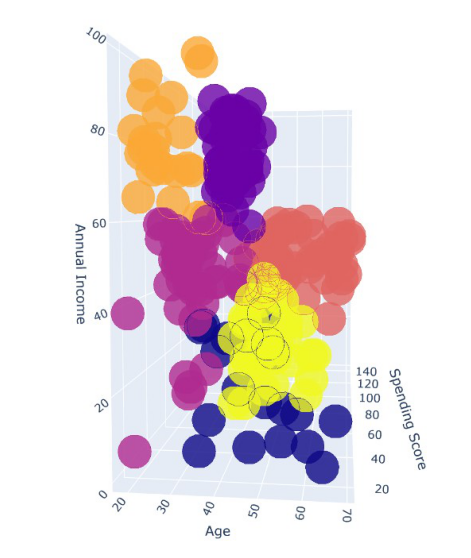

In [ ]:
plt.figure(figsize=(12, 10))
img = plt.imread('drive/MyDrive/google_colab_data/mall_customer_segmentation_data/3d_clustering_output2.jpg')
plt.imshow(img)
plt.axis('off')

(-0.5, 762.5, 558.5, -0.5)

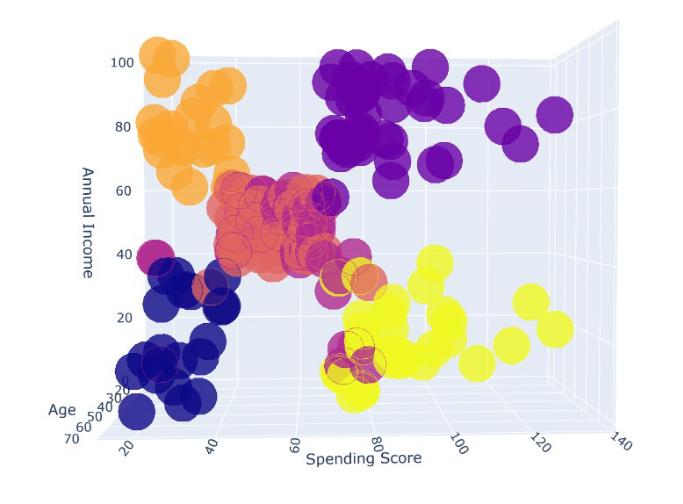

In [ ]:
plt.figure(figsize=(12, 10))
img = plt.imread('drive/MyDrive/google_colab_data/mall_customer_segmentation_data/3d_clustering_output3.jpg')
plt.imshow(img)
plt.axis('off')

> As we can see, the clusters are more easily visible in three dimentional visualization as we had three features.



## Rough description of the clusters
- **Dark-Blue**: Customers with very low annual income and lowest scores.
- **Violet**: Middle-aged customers(30-40 year olds) with high annual income and high spending scores.
- **Orange**: Very Young customers with high annual income and very low spending score.
- **Yellow**: Customers with low income but high spending scores with a mixture of age groups.
- **Magenta**: Young customers with average annual income and average spending scores.
- **Red**: Older customers with average annual income and average spending scores.

# Concluding Suggestions
After analyzing the given dataset, my concluding suggestion for the Marketing team will be: 
- Do something to attract the very Young customers with high annual income and very low spending score. This way, customers will increase. (Orange)
- Hold on to the middle-aged customers(30-40 year olds) with high annual income and high spending scores (Violet).
- Also hold on to the customers with low income but high spending scores with a mixture of age groups. (Yellow)
- Somehow attract the average income customers to increase spending scores (Red and Magenta)

